## Dimensionality reduction with principle components

**Principle component analysis**, or **PCA**, is an alternative to regularization and stright-forward feature elimination. PCA is particularly useful for problems with very large numbers of features compared to the number of training cases. For example, when faced with a problem with many thousands of features and perhaps a few thousand cases, PCA can be a good choice to **reduce the dimensionality** of the feature space.  

PCA is one of a family of transformation methods that reduce dimensionality. PCA is the focus here, since it is the most widely used of these methods. 

The basic idea of PCA is rather simple: Find a linear transformation of the feature space which **projects the majority of the variance** onto a few orthogonal dimensions in the transformed space. The PCA transformation maps the data values to a new coordinate system defined by the principle components. Assuming the highest variance directions, or **components**, are the most informative, low variance components can be eliminated from the space with little loss of information. 

The projection along which the greatest variance occurs is called the **first principle componenent**. The next projection, orthogonal to the first, with the greatest variance is call the **second principle component**. Subsequent components are all mutually orthogonal with decrerasing variance along the projected direction.  

Widely used PCA algorithms compute the components sequentially, starting with the first principle component. This means that it is compuationally efficient to compute the first several components from a very large number of features. Thus, PCA can make problems with very large numbers of features compuationally tractable. 

****
**Note:** It may help your understanding to realize that principle components are a scaled version of the **eigenvectors** of the feature matrix. The scale for each dimensions is given by the **eigenvalues**. The eigenvalues are the fraction of the variance explained by the components. 
****

## A simple example

To cement the concepts of PCA you will now work through a simple example. This example is restricted to 2-d data so that the resuts are easy to visualize. 

As a first step, execute the code in cell below to load the packages required for the rest of this notebook.

In [269]:
## Import packages
library(ggplot2)
library(repr)
library(dplyr)
library(caret)
library(MASS)
library(ROCR)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

The code in the cell below simulates data from a bivariate Normal distribution. The distribution is deliberately centered on $\{ 0,0 \}$ and with unit variance on each dimension. There is considerable covariance between the two dimensions leading to a covariance matrix:

$$cov(X) =  \begin{bmatrix}
  1.0 & 0.6 \\
  0.6 & 1.0
 \end{bmatrix}$$

Given the covariance matrix 100 draws from this distribution are computed using the `mvrnorm` function from the R MASS package. Execute this code:

In [270]:
set.seed(124)
cov = matrix(c(1.0, 0.6, 0.6, 1.0), nrow =2, ncol = 2)
mean = c(0.0, 0.0)

sample = data.frame(mvrnorm(n = 100, mu = mean, Sigma = cov))
names(sample) = c('x','y')
print(dim(sample))
head(sample)

[1] 100   2


x,y
-1.0289674,-1.44872226
0.5476797,-0.47912514
-1.1761978,-0.18875203
0.3192489,0.06053589
1.3990650,1.15101479
1.0575449,0.27422109


To get a feel for this data, execute the code in the cell below to display a plot and examine the result. 

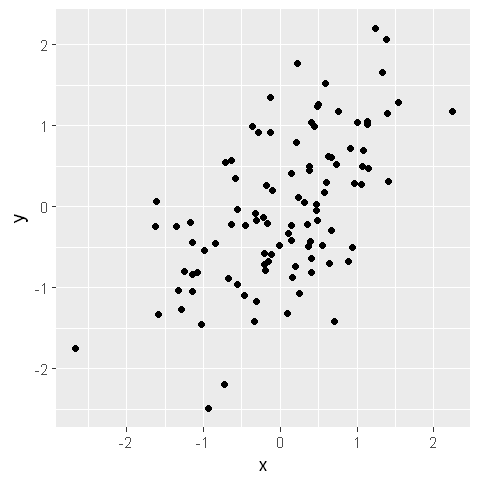

In [271]:
ggplot(sample, aes(x,y)) + geom_point()

You can see that the data have a roughtly eliptical pattern. The correlation between the two dimensions is also visible. 

With the simulated data set created, it is time to compute the PCA model. The code in the cell below does the following:
1. Define a PCA model object using the `PCA` function from the Scikit Learn `decomposition` package.
2. Fit the PCA model to the sample data.
3. Display the ratio of the **variance explained** by each of the components, where, for a matrix X, this ratio is given by:

$$VE(X) = \frac{Var_{X-component}(X)}{Var_{X-total}(X)}$$

Notice that by construction:

$$VE(X) = \sum_{i=1}^N VE_i(X) = 1.0$$

In other words, the sum of the variance explained for each component must add to the total variance or 1.0 for standardized data. 

Execute this code and examine the result.

In [272]:
pca_mod = prcomp(sample)
pca_mod

Standard deviations (1, .., p=2):
[1] 1.1197401 0.5688762

Rotation (n x k) = (2 x 2):
        PC1        PC2
x 0.6595985 -0.7516182
y 0.7516182  0.6595985

Notice that the standard deviation of the first component is several times larger than for the second component. This is exactly the desired result indicating the first principle component explains the majority of the variance of the sample data. Mathematically the components are the eigenvectors and the standard deviations are  the eigenvalues of the data covariance matrix. 

The code in the cell below computes and prints the scaled magnitude of the components. These scaled components must add to 1.0. Execute this code:  

In [273]:
sdev_scaled = pca_mod$sdev**2/sum(pca_mod$sdev**2)
sdev_scaled

[1] 0.7948445 0.2051555

The components are scaled by element wise multiplication with percent variance explained. Execute this code and examine the results. 

In [274]:
scaled_pca = data.frame(matrix(c(0,0,0,0), nrow = 2, ncol = 2))
for(i in 1:2){
    scaled_pca[i,] = pca_mod$rotation[i,] * sdev_scaled
}
names(scaled_pca) = c('PC1','PC2')
str(scaled_pca)

'data.frame':	2 obs. of  2 variables:
 $ PC1: num  0.524 0.597
 $ PC2: num  -0.154 0.135


The two component vectors have their origins at $[ 0,0 \}$, and are quite different magnitude, and are pointing in different directions. To better understand how the projections of the components relate to the data, execute the code to plot the data along with the principle components. Execute this code: 

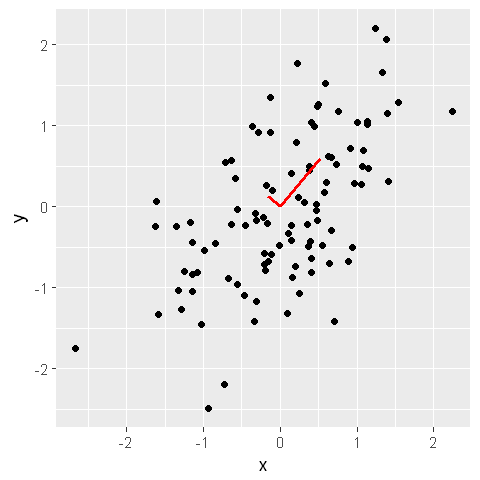

In [275]:
## Find the slopes
s1 = data.frame(x = c(0.0, scaled_pca$PC1[1]), y = c(0.0, scaled_pca$PC1[2]))
s2 = data.frame(x = c(0.0, scaled_pca$PC2[1]), y = c(0.0, scaled_pca$PC2[2]))

## Plot the data with the PCs
ggplot(sample, aes(x,y)) + geom_point() +
        geom_line(data = s1, aes(x,y), color = 'red', size = 1) +
        geom_line(data = s2, aes(x,y), color = 'red', size = 1)

Notice the the fist principle component (the long red line) is along the direction of greatest variance of the data. This is as expected. The short red line is along the direction of the second principle component. The lengths of these lines are the variance in the directions of the projection. 

The ultimate goal of PCA is to transform data to a coordinate system with the highest variance directions along the axes. The `transform` function in the cell below computes the projections of the data onto the new coordinate frames using matrix multiplication. Execute this code to apply the transform and plot the result: 

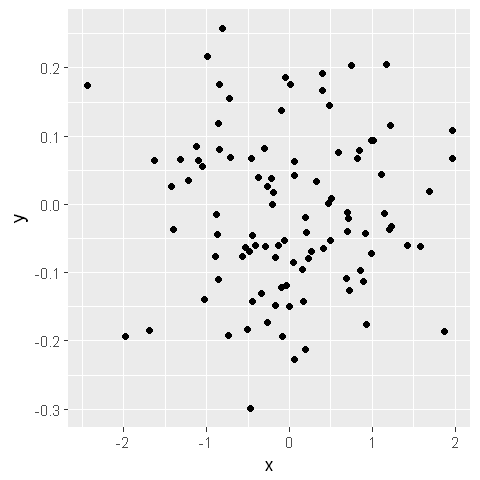

In [276]:
pca_transform = function(df, pca, ncomps){
    data.frame(as.matrix(df) %*% as.matrix(pca)[,1:ncomps])
}

trans_sample = pca_transform(sample, scaled_pca, 2)
names(trans_sample) = c('x', 'y')
ggplot(trans_sample, aes(x,y)) + geom_point()

Notice that the scale along these two coordinates are quite different. The first principle component is along the horizontal axis. The range of values on this direction is in the range of about $\{ -2.5,2.5 \}$. The range of values on the vertical axis or second principle component are only about $\{ -0.2, 0.3 \}$. It is clear that most of the variance is along the direction of the fist principle component. 

## Load Features and Labels

Keeping the foregoing simple example in mind, it is time to apply PCA to some real data. 

The code in the cell below loads the dataset which has had the the following preprocessing:
1. Cleaning missing values.
2. Aggregating categories of certain categorical variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example: 

In [277]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
credit[,'X'] = NULL
credit[,'Customer_ID'] = NULL
dim(credit)
str(credit)

[1] 999  21

'data.frame':	999 obs. of  21 variables:
 $ checking_account_status : Factor w/ 4 levels "< 0 DM","> 200 DM or salary assignment",..: 3 4 1 1 4 4 3 4 3 3 ...
 $ loan_duration_mo        : int  48 12 42 24 36 24 36 12 30 12 ...
 $ credit_history          : Factor w/ 5 levels "all loans at bank paid",..: 3 2 3 5 3 3 3 3 2 3 ...
 $ purpose                 : Factor w/ 10 levels "business","car (new)",..: 8 5 6 2 5 6 3 8 2 2 ...
 $ loan_amount             : int  5951 2096 7882 4870 9055 2835 6948 3059 5234 1295 ...
 $ savings_account_balance : Factor w/ 5 levels "< 100 DM",">= 1000 DM",..: 1 1 1 1 5 4 1 2 1 1 ...
 $ time_employed_yrs       : Factor w/ 5 levels "< 1 year",">= 7 years",..: 3 4 4 3 3 2 3 4 5 1 ...
 $ payment_pcnt_income     : int  2 2 2 3 2 3 2 2 4 3 ...
 $ gender_status           : Factor w/ 4 levels "female-divorced/separated/married",..: 1 4 4 4 4 4 4 2 3 1 ...
 $ other_signators         : Factor w/ 3 levels "co-applicant",..: 3 3 2 3 3 3 3 3 3 3 ...
 $ time_in_residence    

There are 20 features in this data set. 

The prcomp function can only work with numeric matrices. Therefore, the categorical features are dummy variable encoded. Executed the code in the cell below to compute the encoding for the dummy variables. 

In [278]:
dummies = dummyVars(bad_credit ~ ., data = credit)

The code in the cell below to split the data set into test and training subsets and dummy variable encode the categorical features. The Caret `createDataPartion` function is used  to randomly split the dataset. The `perdict` method dummy variable encodes the categorical features. Execute this code and examine the result. 

In [279]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(credit[,'credit_history'], times = 1, p = 0.7, list = FALSE)
training = credit[partition,] # Create the training feature sample
training_label = credit[partition, 'bad_credit'] # Subset training labels
training = predict(dummies, newdata = training) # transform categorical to dummy vars
dim(training)
test = credit[-partition,] # Create the test sample
test_label = credit[-partition, 'bad_credit'] # Subset training labels
test = predict(dummies, newdata = test) # transform categorical to dummy vars
dim(test)
head(training)

[1] 701  61

[1] 298  61

,checking_account_status.< 0 DM,checking_account_status.> 200 DM or salary assignment,checking_account_status.0 - 200 DM,checking_account_status.none,loan_duration_mo,credit_history.all loans at bank paid,credit_history.critical account - other non-bank loans,credit_history.current loans paid,credit_history.no credit - paid,credit_history.past payment delays,...,number_loans,job_category.highly skilled,job_category.skilled,job_category.unemployed-unskilled-non-resident,job_category.unskilled-resident,dependents,telephone.none,telephone.yes,foreign_worker.no,foreign_worker.yes
1,0,0,1,0,48,0,0,1,0,0,...,1,0,1,0,0,1,1,0,0,1
4,1,0,0,0,24,0,0,0,0,1,...,2,0,1,0,0,2,1,0,0,1
6,0,0,0,1,24,0,0,1,0,0,...,1,0,1,0,0,1,1,0,0,1
7,0,0,1,0,36,0,0,1,0,0,...,1,1,0,0,0,1,0,1,0,1
9,0,0,1,0,30,0,1,0,0,0,...,2,1,0,0,0,1,1,0,0,1
10,0,0,1,0,12,0,0,1,0,0,...,1,0,1,0,0,1,1,0,0,1


Before performaing PCA all features must be zero mean and unit variance. Failure to do so will result in biased computation of the components and scales. The `preProcess` function from Caret is used to compute scaling of the training data. The same scaling is applied to the test data. Execute the code in the cell below to scale the features. 

In [280]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'age_yrs')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,loan_duration_mo,loan_amount,payment_pcnt_income,age_yrs
1,2.2080823,0.9731062,-0.88582584,-1.17991811
4,0.2337638,0.5805881,0.01542803,1.56006911
6,0.2337638,-0.1583336,0.01542803,1.56006911
7,1.2209231,1.3351234,-0.88582584,-0.03089121
9,0.7273434,0.7127589,0.91668189,-0.64959800
10,-0.7533954,-0.7175176,0.01542803,-0.91475805


## Compute principle components

The code in the cell below computes the principle components for the training feature subset. Execute this code:

In [281]:
pca_credit = prcomp(training)

Execute the code in the cell below to print the variance explained for each component and the sum of the variance explained:

In [282]:
var_exp = pca_credit$sdev**2/sum(pca_credit$sdev**2)
var_exp
sum(var_exp)

[1] 1.454336e-01 1.292008e-01 8.350921e-02 7.442332e-02 4.538342e-02
 [6] 4.121424e-02 3.761469e-02 3.043839e-02 2.843394e-02 2.701308e-02
[11] 2.432247e-02 2.327961e-02 2.219194e-02 2.184403e-02 2.047171e-02
[16] 1.859786e-02 1.636445e-02 1.601435e-02 1.505207e-02 1.432733e-02
[21] 1.300623e-02 1.277639e-02 1.099331e-02 1.038650e-02 1.000854e-02
[26] 9.789121e-03 9.016278e-03 8.774355e-03 8.022685e-03 7.570142e-03
[31] 6.833847e-03 6.268183e-03 5.509760e-03 5.238912e-03 5.013295e-03
[36] 4.720333e-03 4.469518e-03 4.224042e-03 3.705657e-03 3.499997e-03
[41] 3.170361e-03 2.952510e-03 2.537570e-03 2.065037e-03 1.437285e-03
[46] 1.251170e-03 8.778268e-04 7.507080e-04 2.434032e-31 3.459062e-32
[51] 2.719387e-32 2.625818e-32 1.533348e-32 1.167521e-32 8.828202e-33
[56] 5.314568e-33 2.850638e-33 1.626838e-33 9.327426e-34 7.260375e-34
[61] 3.414108e-34

[1] 1

These numbers are a bit abstract. However, you can see that the variance ratios are in descending order and that the sum is 1.0. 

Execute the code in the cell below to create a plot of the explained variance vs. the component:  

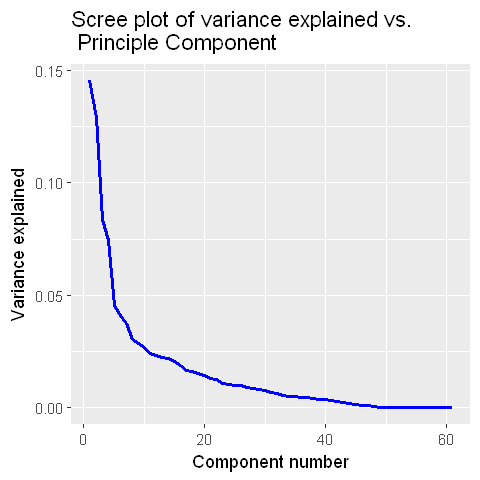

In [283]:
plot_scree = function(pca_mod){
    ## Plot as variance explained
    df = data.frame(x = 1:length(var_exp), y = var_exp)
    ggplot(df, aes(x,y)) + geom_line(size = 1, color = 'blue') +
    xlab('Component number') + ylab('Variance explained') +
    ggtitle('Scree plot of variance explained vs. \n Principle Component')
}

plot_scree(pca_credit)

This curve is often referred to as a **scree plot**. Notice that the explained variance decreases rapidly until the 10th component and then slowly, thereafter. The first few components explain a large fraction of the variance and therefore contain much of the explanatory information in the data. The components with small explained variance are unlikely to contain much explanatory information. Often the inflection point or 'knee' in the scree curve is used to choose the number of components selected. 

Now it is time to create a PCA model with a reduced number of components. The code in the cell below trains and fits a PCA model with 10 components, and then transforms the features using that model. Execute this code. 

In [284]:
## Compute first 10 PCA components 
pca_credit_10 = prcomp(training, rank = 10)

## Scale the eigenvalues
var_exp_10 = pca_credit_10$sdev**2/sum(pca_credit_10$sdev**2)
Nrow = nrow(pca_credit_10$rotation)
Ncol = ncol(pca_credit_10$rotation)
scaled_pca_10 = data.frame(matrix(rep(0, Nrow * Ncol), nrow = Nrow, ncol = Ncol))

## Scale the rotations
for(i in 1:Nrow){
    scaled_pca_10[i,] = pca_credit_10$rotation[i,] * var_exp_10[1:Ncol]
}

## Print the dimensions of the scalled rotations and the first component
dim(scaled_pca_10)
pca_credit_10$rotation[1:10,1]

[1] 61 10

checking_account_status.< 0 DM 
                                          -0.003283701 
 checking_account_status.> 200 DM or salary assignment 
                                           0.021903320 
                    checking_account_status.0 - 200 DM 
                                          -0.021224062 
                          checking_account_status.none 
                                           0.002604443 
                                      loan_duration_mo 
                                          -0.582557235 
                 credit_history.all loans at bank paid 
                                          -0.003863080 
credit_history.critical account - other non-bank loans 
                                          -0.013599984 
                     credit_history.current loans paid 
                                           0.071598478 
                       credit_history.no credit - paid 
                                          -0.013201315 
                    credit_history.past payment delays 
                                          -0.040934099

The scaled rotation matrix has dimensions of 61 rows and 10 columns. You can see the first 10 elements of the first rotation. Multiplying these numbers by the features rotate each row (case) to the new coordinate system.

## Compute and evaluate a logistic regression model

Next, you will compute and evaluate a logistic regression model using the features transformed by the first 10 principle components. The code in the cell below performs the matrix multiplication between the features and on the 

In [285]:
training_10 = training %*% as.matrix(scaled_pca_10)
dim(training_10)

[1] 701  10

There are now 10 transformed features. 

Now you will now construct and evaluate a logistic regression model by executing the code below:

In [302]:
## Construct a data frame with the transformed features and label
training_10 = data.frame(training_10)
training_10[,'bad_credit'] = training_label

## Create a weight vector for the training cases.
weights = ifelse(training_10$bad_credit == 1, 0.66, 0.34)

## Define and fit the logistic regression model
set.seed(5566)
logistic_mod_10 = glm(bad_credit ~ ., data = training_10, 
                      weights = weights, family = quasibinomial)
logistic_mod_10$coefficients

(Intercept)           X1           X2           X3           X4           X5 
  0.09802008  -1.72329170  -1.41309296  -3.55400446   5.14280831  19.17894189 
          X6           X7           X8           X9          X10 
-11.31456219  26.52252439   4.73664055  10.25087300  -9.30381732

Notice that there are now 10 regression coefficients, one for each component plus an intercept. This number is in contrast to the 61 features in the dummy variable array. 

In order to test the model, the test feature array must also be transformed. Execute the code in the cell below to apply the PCA transformation to the test features:

In [296]:
test_10 = test %*% as.matrix(scaled_pca_10)
test_10 = data.frame(test_10)
test_10[,'bad_credit'] = test_label
dim(test_10)

[1] 298  11

Execute the code in the cell below to score the model using the test data:

In [297]:
score_model = function(df, threshold){
    df$score = ifelse(df$probs > threshold, 1, 0)
    df
}

test_10$probs = predict(logistic_mod_10, newdata = test_10, type = 'response')
test_10 = score_model(test_10, 0.5)
test_10[1:10, c('bad_credit','score', 'probs')]

,bad_credit,score,probs
2,0,0,0.18955827
3,0,1,0.86591768
5,0,0,0.39190522
8,0,0,0.13024404
14,0,1,0.70334039
16,0,0,0.07764378
18,1,1,0.83965675
25,0,0,0.47885993
27,0,0,0.31949145
30,0,0,0.43611835


Execute the code in the cell below to evaluate the 10 PCA component logistic regression model:

                Negative Positive
Actual Negative      161       59
Actual Positive       21       57

accuracy  = 0.732 
precision = 0.491 
recall    = 0.731 
F1        = 0.588 


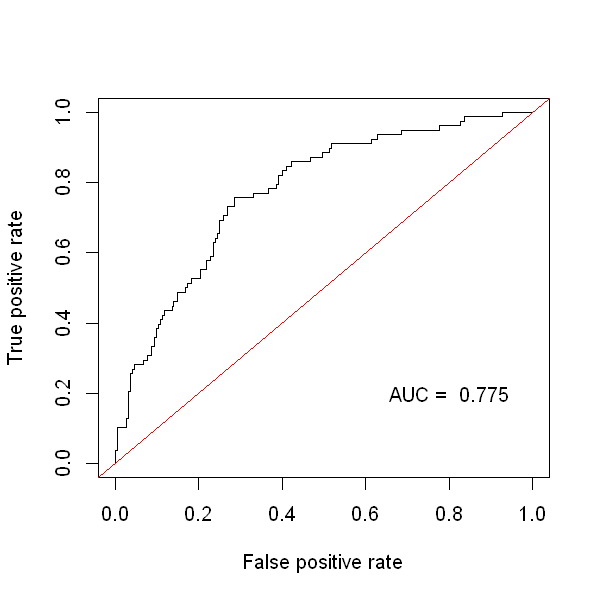

In [298]:
logistic.eval <- function(df){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf = ifelse(df$bad_credit == 1 & df$score == 1, 'TP',
                    ifelse(df$bad_credit == 0 & df$score == 1, 'FP',
                           ifelse(df$bad_credit == 0 & df$score == 0, 'TN', 'FN')))

  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
  
  ## Confusion matrix as data frame
  out = data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) = c('Actual Negative', 'Actual Positive')
  print(out)  
  
  # Compute and print metrics
  P = TP/(TP + FP)
  R = TP/(TP + FN)  
  F1 = 2*P*R/(P+R)  
  cat('\n')
  cat(paste('accuracy  =', as.character(round((TP + TN)/(TP + TN + FP + FN), 3)), '\n'))      
  cat(paste('precision =', as.character(round(P, 3)), '\n'))     
  cat(paste('recall    =', as.character(round(R, 3)), '\n'))
  cat(paste('F1        =', as.character(round(F1,3)),'\n'))
}

ROC_AUC = function(df){
    options(repr.plot.width=5, repr.plot.height=5)
    pred_obj = prediction(df$probs, df$bad_credit)
    perf_obj <- performance(pred_obj, measure = "tpr", x.measure = "fpr")
    AUC = performance(pred_obj,"auc")@y.values[[1]] # Access the AUC from the slot of the S4 object
    plot(perf_obj)
    abline(a=0, b= 1, col = 'red')
    text(0.8, 0.2, paste('AUC = ', as.character(round(AUC, 3))))
}

logistic.eval(test_10)
ROC_AUC(test_10)

These results are reasonably good. Recall, accuracy and AUC have reasonble values, however precision and F1 are low. Is it possible that more PCA components are required to achieve a good model? 

## Add more components to the model

Now you will compute and evaluate a logistic regression model using the first 20 principle components. You will compare this model to the one created with 10 principle components. 

Execute the code below to transform the training features using the first 20 principle components. 

In [291]:
## Compute first 10 PCA components 
pca_credit_20 = prcomp(training, rank = 20)

## Scale the eigenvalues
var_exp_20 = pca_credit_20$sdev**2/sum(pca_credit_20$sdev**2)
Nrow = nrow(pca_credit_20$rotation)
Ncol = ncol(pca_credit_20$rotation)
scaled_pca_20 = data.frame(matrix(rep(0, Nrow * Ncol), nrow = Nrow, ncol = Ncol))

## Scale the rotations
for(i in 1:Nrow){
    scaled_pca_20[i,] = pca_credit_20$rotation[i,] * var_exp_20[1:Ncol]
}

## Print the dimensions of the scalled rotations and the first component
dim(scaled_pca_20)

[1] 61 20

There are now 20 components in the PCA model. 

The code in the cell below computes the transformed feature set and creates a logistic regression model from this feature set. Execute this code.

In [303]:
## Construct a data frame with the transformed features and label
training_20 = training %*% as.matrix(scaled_pca_20)
training_20 = data.frame(training_20)
training_20[,'bad_credit'] = training_label

weights = ifelse(training_20$bad_credit == 1, 0.66, 0.34)

## Define and fit the logistic regression model
set.seed(5566)
logistic_mod_20 = glm(bad_credit ~ ., data = training_20, 
                      weights = weights, family = quasibinomial)
logistic_mod_20$coefficients

(Intercept)           X1           X2           X3           X4           X5 
 -0.07845457  -1.90475206  -1.65737947  -3.79704179   5.70262771  21.06472844 
          X6           X7           X8           X9          X10          X11 
-11.92240844  28.92927628   4.42073511  11.16148336 -10.23116397  24.06838460 
         X12          X13          X14          X15          X16          X17 
 -6.28420062  20.92758959  -2.94852779 -43.07617277   4.00035455   6.28323959 
         X18          X19          X20 
 -1.53959224   5.87823114 -23.29220999

The code in the cell below scores the logistic regression model and displays performance metrics, the ROC curve, and the AUC. Execute this code and examine the result. 

                Negative Positive
Actual Negative      152       68
Actual Positive       28       50

accuracy  = 0.678 
precision = 0.424 
recall    = 0.641 
F1        = 0.51 


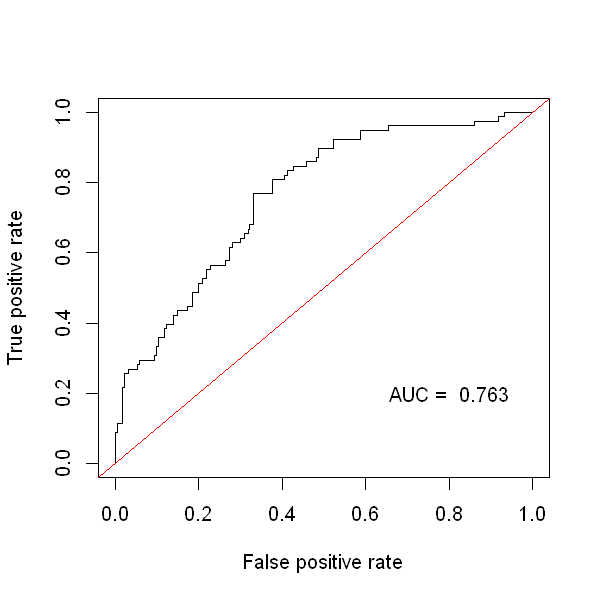

In [304]:
## Create the transformed test dataset
test_20 = test %*% as.matrix(scaled_pca_20)
test_20 = data.frame(test_20)
test_20[,'bad_credit'] = test_label

## Score the model
test_20$probs = predict(logistic_mod_20, newdata = test_20, type = 'response')
test_20 = score_model(test_20, 0.5)

## Evaluate the model
logistic.eval(test_20)
ROC_AUC(test_20)

The metrics for the 20 component model are nearly the same as for the 10 component model. It appears that 10 components is enough to represent the information in the feature set. 

## Summary

In this lab you have applied principle component analysis to dimensionality reduction for suppervised machine learing. The first components computed contain most of the available information. When faced with large number of feautures, PCA is an effective way to make supervised machine learning models tractable. 

Specifically in this lab you have:
1. Computed PCA models with different numbers of components.
2. Compared logistic regression models with different numbers of components. In this case, using 10 components produced a good model. Extending this to 20 components gained little if anything. In summary the dimensionality of the original 61 dummy variable array to just 10 components. 